In [1]:
import pandas as pd

data = pd.read_csv('downsampled_data.csv')

Text(0.5, 1.0, 'Amplitude vs Time')

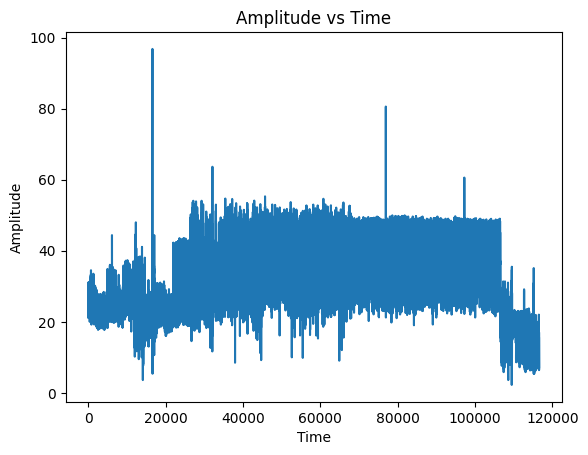

In [2]:
plot = data['amplitude3_1'].plot()
plot.set_xlabel('Time')
plot.set_ylabel('Amplitude')
plot.set_title('Amplitude vs Time')

# Add Hampel Filter 

In [3]:
from scipy.stats import median_abs_deviation

In [4]:
def hampel_filter(data, window_size=3, n_sigma=3):
    median = data.rolling(window=window_size, center=True).median()
    mad = median_abs_deviation(data, scale='normal')
    threshold = n_sigma * mad
    outlier_mask = (data - median).abs() > threshold
    data[outlier_mask] = median[outlier_mask]
    return data

In [5]:

columns_to_filter = [col for col in data.columns if col not in ['id', 'time', 'activity']]
data[columns_to_filter] = data[columns_to_filter].apply(hampel_filter)


Text(0.5, 1.0, 'Amplitude vs Time')

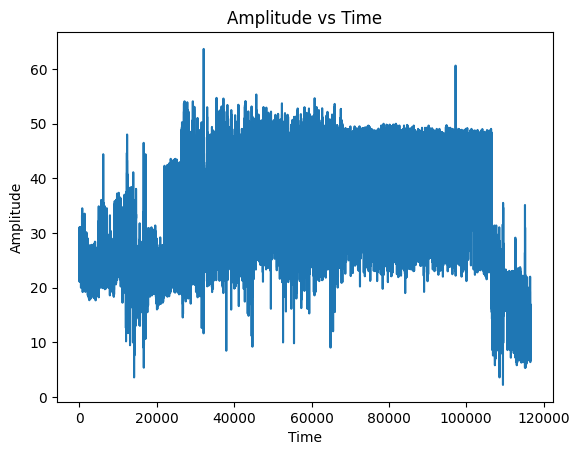

In [6]:
plot = data['amplitude3_1'].plot()
plot.set_xlabel('Time')
plot.set_ylabel('Amplitude')
plot.set_title('Amplitude vs Time')



# Get X and and Y

In [7]:
X = data.drop(columns=['activity', 'id', 'time'])

Y  = data['activity']

# Do PCA

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.80, svd_solver='full')

pca.fit(X)

PCA(n_components=0.8, svd_solver='full')

In [9]:
from joblib import dump

dump(pca, './models/pca_model.joblib')

['./models/pca_model.joblib']

In [10]:
X_pca = pd.DataFrame(pca.transform(X))

In [11]:
X_pca.shape

(116575, 4)

In [13]:
X_pca

,0,1,2,3
0,-34.100675,47.030409,25.022205,-1.588124
1,-34.990348,45.722405,15.611436,-0.693663
2,-35.198248,46.948700,20.830155,-5.560692
3,-33.740542,47.866320,17.248049,-3.770676
4,-34.958565,48.925219,21.351211,-0.052693
...,...,...,...,...
116570,-45.531796,63.253341,-64.996857,-9.251094
116571,-43.686812,59.055929,0.549233,-24.356188
116572,-44.779325,60.026135,6.667479,-11.462366
116573,-47.552903,57.614776,-2.322557,-21.343527


<Axes: >

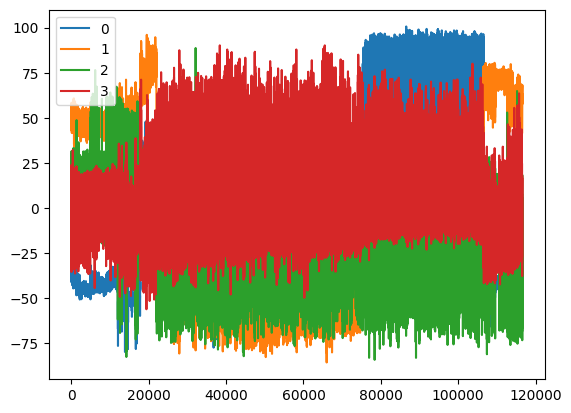

In [15]:
X_pca.plot()


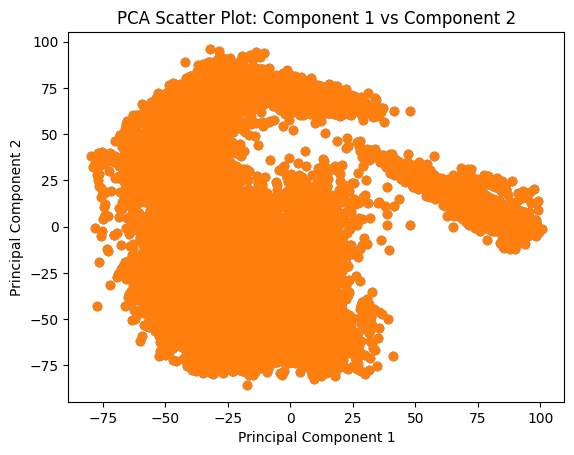

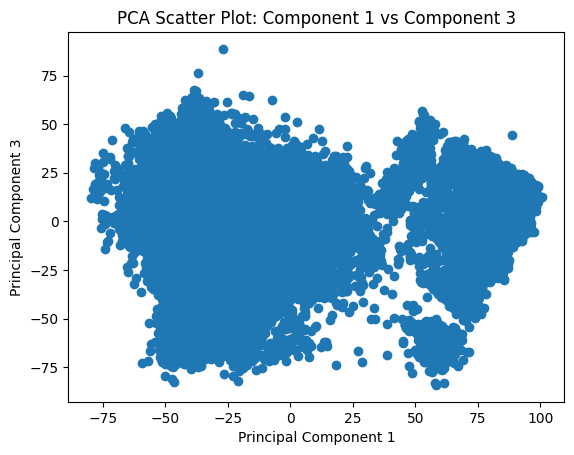

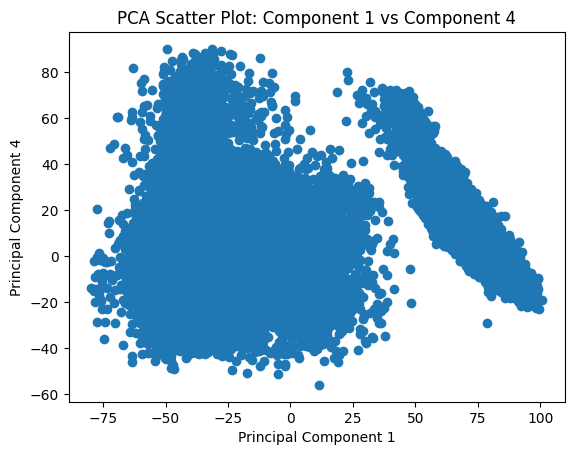

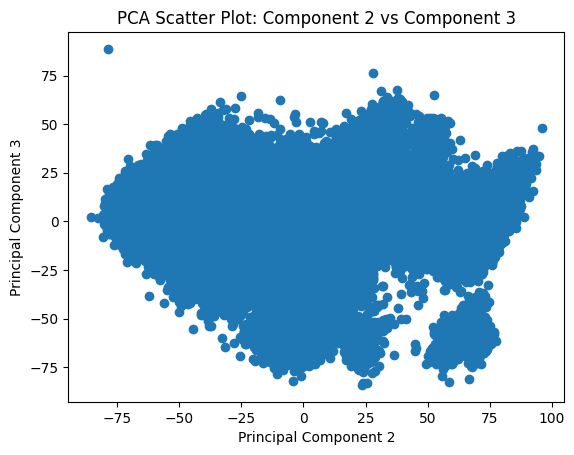

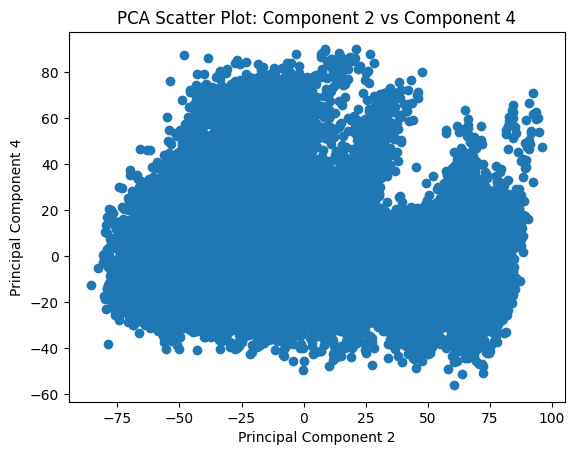

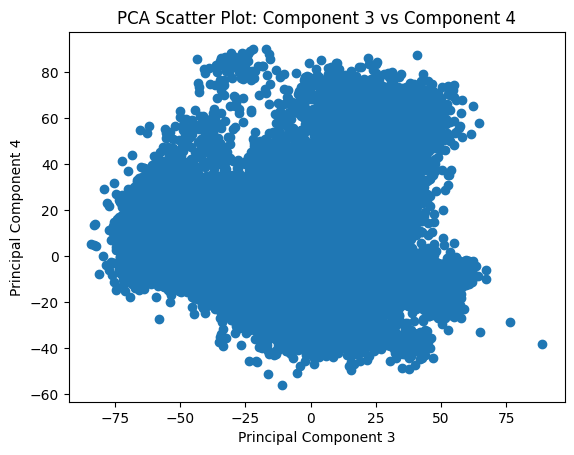

In [16]:
import matplotlib.pyplot as plt

plt.scatter(X_pca[0], X_pca[1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
import matplotlib.pyplot as plt

num_components = X_pca.shape[1]

for i in range(num_components):
    for j in range(i+1, num_components):
        plt.scatter(X_pca[i], X_pca[j])
        plt.xlabel(f'Principal Component {i+1}')
        plt.ylabel(f'Principal Component {j+1}')
        plt.title(f'PCA Scatter Plot: Component {i+1} vs Component {j+1}')
        plt.show()
plt.show()


Save PCA data to csv

In [17]:
X_pca.to_csv('pca.csv', index=False)

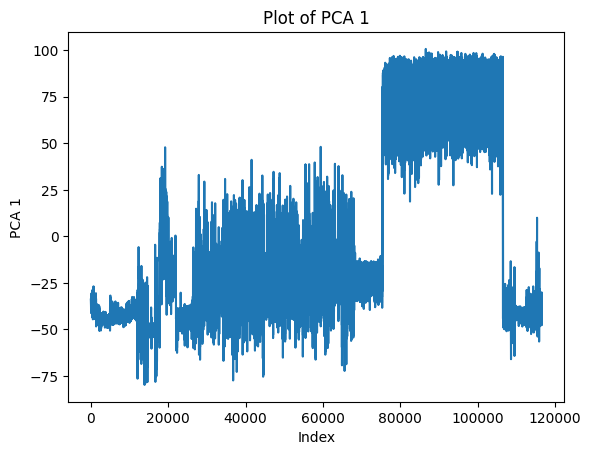

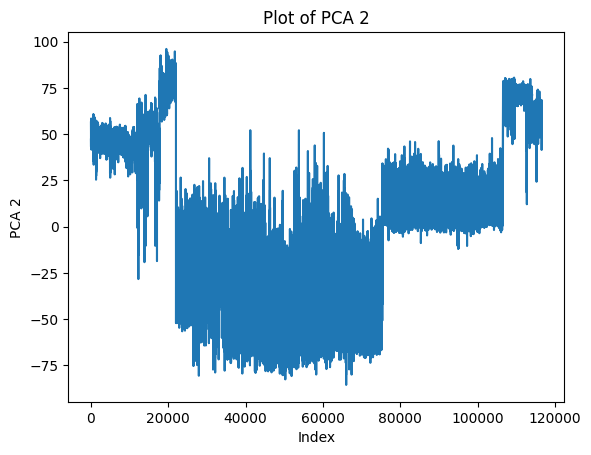

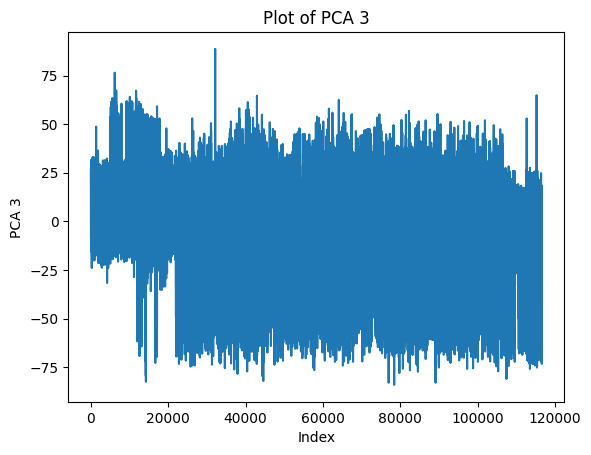

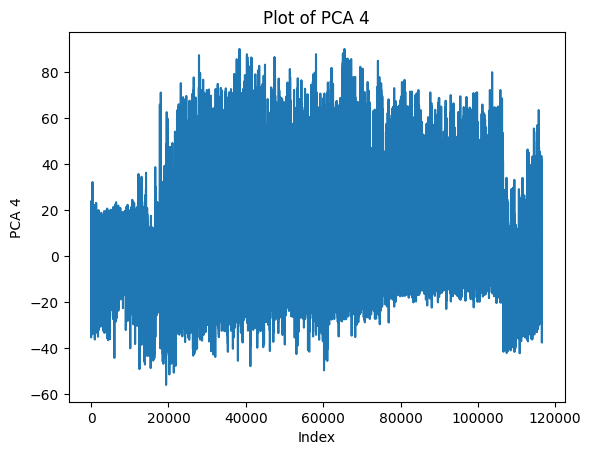

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

for column in X_pca.columns:
    sns.lineplot(data=X_pca[column])
    plt.xlabel('Index')
    plt.ylabel(f'PCA {column+1}')
    plt.title(f'Plot of PCA {column+1}')
    plt.show()


# Apply low pass filter

In [19]:
from scipy.signal import butter, filtfilt

# Define the filter parameters
order = 4
cutoff_freq = 0.005

# Create the filter coefficients
b, a = butter(order, cutoff_freq, btype='low', analog=False, output='ba')

filtered_data = X_pca.apply(lambda x: filtfilt(b, a, x))

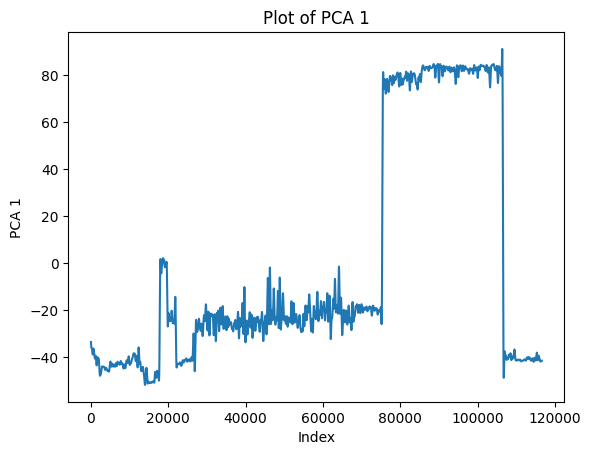

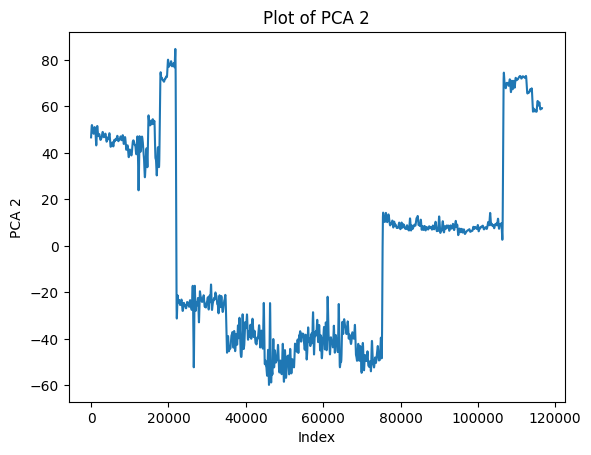

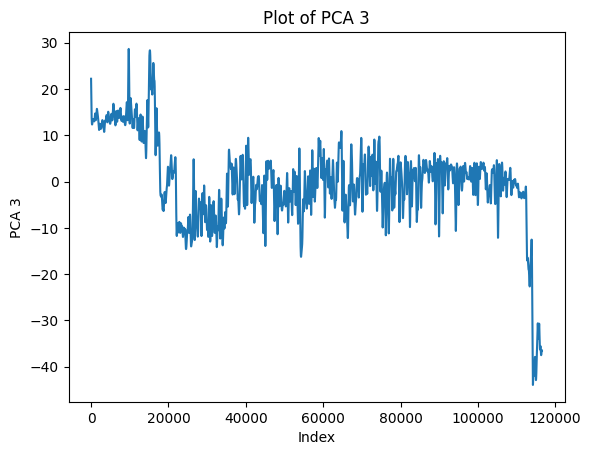

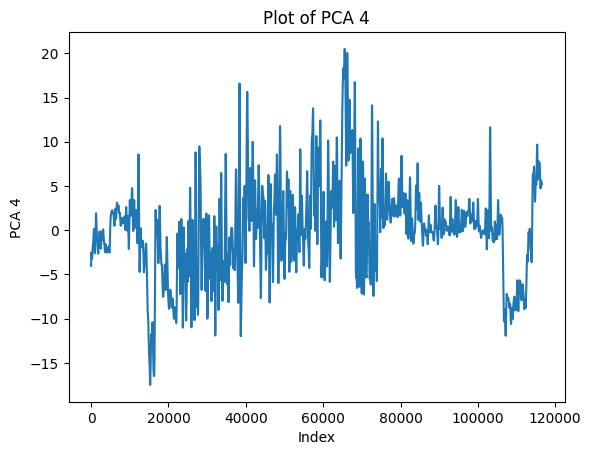

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

for column in filtered_data.columns:
    sns.lineplot(data=filtered_data[column])
    plt.xlabel('Index')
    plt.ylabel(f'PCA {column+1}')
    plt.title(f'Plot of PCA {column+1}')
    plt.show()


# Get wavelet variances

In [21]:
activity_zero_rows = X_pca[Y == 0]

activity_zero_rows_count = len(activity_zero_rows)
print(activity_zero_rows_count)

45750


In [22]:
activity_one_rows = X_pca[Y == 1]

activity_one_rows_count = len(activity_one_rows)
print(activity_one_rows_count)

16850


In [23]:
activity_two_rows = X_pca[Y == 2]

activity_two_rows_count = len(activity_two_rows)
print(activity_two_rows_count)

14275


In [24]:
activity_three_rows = X_pca[Y == 3]

activity_three_rows_count = len(activity_three_rows)
print(activity_three_rows_count)

10950


In [25]:
activity_four_rows = X_pca[Y == 4]

activity_four_rows_count = len(activity_four_rows)
print(activity_four_rows_count)

15923


In [26]:
activity_five_rows = X_pca[Y == 5]

activity_five_rows_count = len(activity_five_rows)
print(activity_five_rows_count)

12827


In [27]:
import pywt
import numpy as np

In [28]:
wavelet_name = 'gaus1'

scales = np.arange(1, 128)


In [35]:
wavelet_variances = np.empty((0, 26))

for i in range(activity_zero_rows_count // 25):
    csi = activity_zero_rows.iloc[i*25:i*25+25, 0]
    coefficients, frequencies = pywt.cwt(csi, scales, wavelet_name)
    wavelet_variance = np.sum(coefficients**2, axis=0)
    wavelet_variances = np.vstack((wavelet_variances, np.append(wavelet_variance, 0)))

In [36]:
for i in range(activity_one_rows_count // 25):
	csi = activity_one_rows.iloc[i*25:i*25+25, 0]
	coefficients, frequencies = pywt.cwt(csi, scales, wavelet_name)
	wavelet_variance = np.sum(coefficients**2, axis=0)
	wavelet_variances = np.vstack((wavelet_variances, np.append(wavelet_variance, 1)))

In [37]:
for i in range(activity_two_rows_count // 25):
	csi = activity_two_rows.iloc[i*25:i*25+25, 0]
	coefficients, frequencies = pywt.cwt(csi, scales, wavelet_name)
	wavelet_variance = np.sum(coefficients**2, axis=0)
	wavelet_variances = np.vstack((wavelet_variances, np.append(wavelet_variance, 2)))

In [38]:
for i in range(activity_three_rows_count // 25):
	csi = activity_three_rows.iloc[i*25:i*25+25, 0]
	coefficients, frequencies = pywt.cwt(csi, scales, wavelet_name)
	wavelet_variance = np.sum(coefficients**2, axis=0)
	wavelet_variances = np.vstack((wavelet_variances, np.append(wavelet_variance, 3)))

In [39]:
for i in range(activity_four_rows_count // 25):
	csi = activity_four_rows.iloc[i*25:i*25+25, 0]
	coefficients, frequencies = pywt.cwt(csi, scales, wavelet_name)
	wavelet_variance = np.sum(coefficients**2, axis=0)
	wavelet_variances = np.vstack((wavelet_variances, np.append(wavelet_variance, 4)))

In [41]:
for i in range(activity_five_rows_count // 25):
	csi = activity_five_rows.iloc[i*25:i*25+25, 0]
	coefficients, frequencies = pywt.cwt(csi, scales, wavelet_name)
	wavelet_variance = np.sum(coefficients**2, axis=0)
	wavelet_variances = np.vstack((wavelet_variances, np.append(wavelet_variance, 5)))

In [42]:
wavelet_variances.shape

(4662, 26)

In [43]:
wav = pd.DataFrame(wavelet_variances)

wav.to_csv('wavelet.csv', index=False)

In [6]:
#optional
import pandas as pd

wav = pd.read_csv('wavelet.csv')

In [10]:
wav.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,844246.771846,766322.702933,676362.874956,582653.055304,487632.724253,393843.605076,305121.373537,223931.271079,154857.408559,94572.790876,...,93226.921534,153166.942791,222545.054532,303888.999399,391866.465254,486724.818599,582024.721112,676678.812110,766812.986354,0.0
1,851375.348222,774111.417021,683931.984637,589071.573066,493228.136977,398480.843524,308753.153052,226674.010000,156393.591442,95865.394673,...,93312.556147,153424.613589,223178.694361,305063.310803,394014.921374,489715.817570,586245.862100,681382.519576,772321.154907,0.0
2,884561.046834,805462.679879,712995.277572,616338.739829,518113.814785,420973.478929,328356.639683,243127.911778,169764.937039,105944.804686,...,90432.600876,151332.371735,222692.063303,307100.479375,399330.775529,498983.142903,599785.024406,699926.556974,796329.385742,0.0
3,875623.235671,791263.938793,693748.534380,592467.523342,491291.727575,392664.217563,300174.393228,216875.012549,146730.350371,86788.007042,...,108194.982183,172722.918894,246321.839503,331850.274237,423853.145715,521895.203145,620060.792082,716353.006580,807798.021463,0.0
4,862933.383222,782687.639338,689386.984217,592237.854560,493949.114379,397407.064741,306431.404397,223540.773615,153226.074482,92582.391814,...,98969.366795,160784.411899,231720.006889,314865.545939,404502.003237,500760.392064,597458.846946,693382.098300,785308.674817,0.0


In [13]:
X = wav.drop(columns=['25'])

Y = wav['25']

In [14]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,844246.771846,766322.702933,676362.874956,582653.055304,487632.724253,393843.605076,305121.373537,223931.271079,154857.408559,94572.790876,...,48111.797898,93226.921534,153166.942791,222545.054532,303888.999399,391866.465254,486724.818599,582024.721112,676678.812110,766812.986354
1,851375.348222,774111.417021,683931.984637,589071.573066,493228.136977,398480.843524,308753.153052,226674.010000,156393.591442,95865.394673,...,47995.749940,93312.556147,153424.613589,223178.694361,305063.310803,394014.921374,489715.817570,586245.862100,681382.519576,772321.154907
2,884561.046834,805462.679879,712995.277572,616338.739829,518113.814785,420973.478929,328356.639683,243127.911778,169764.937039,105944.804686,...,45050.099684,90432.600876,151332.371735,222692.063303,307100.479375,399330.775529,498983.142903,599785.024406,699926.556974,796329.385742
3,875623.235671,791263.938793,693748.534380,592467.523342,491291.727575,392664.217563,300174.393228,216875.012549,146730.350371,86788.007042,...,58605.868118,108194.982183,172722.918894,246321.839503,331850.274237,423853.145715,521895.203145,620060.792082,716353.006580,807798.021463
4,862933.383222,782687.639338,689386.984217,592237.854560,493949.114379,397407.064741,306431.404397,223540.773615,153226.074482,92582.391814,...,52075.319477,98969.366795,160784.411899,231720.006889,314865.545939,404502.003237,500760.392064,597458.846946,693382.098300,785308.674817


In [15]:
Y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 25, dtype: float64

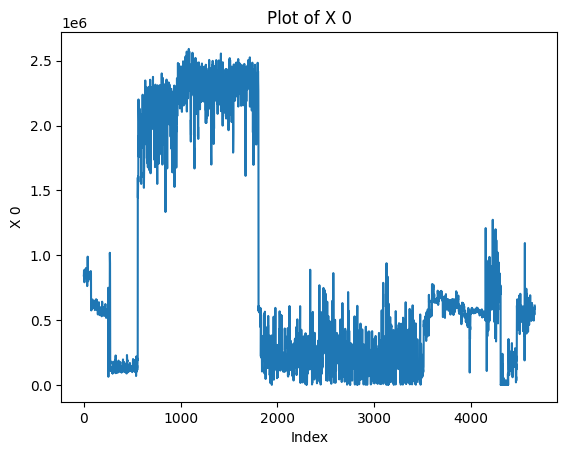

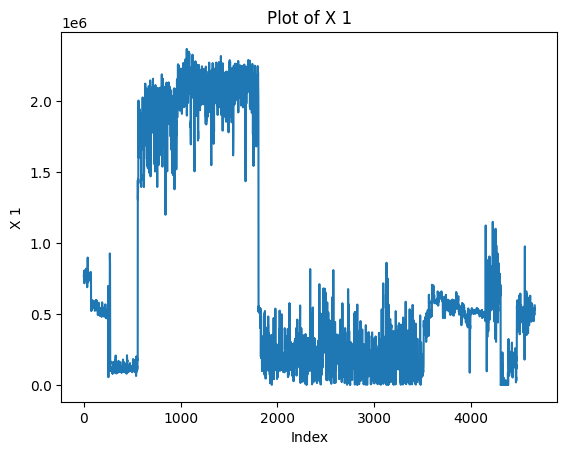

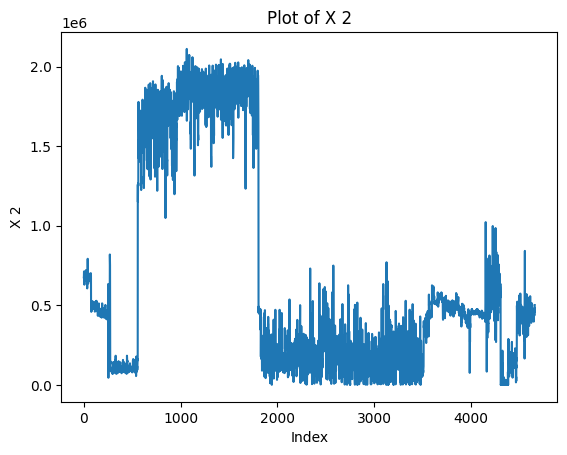

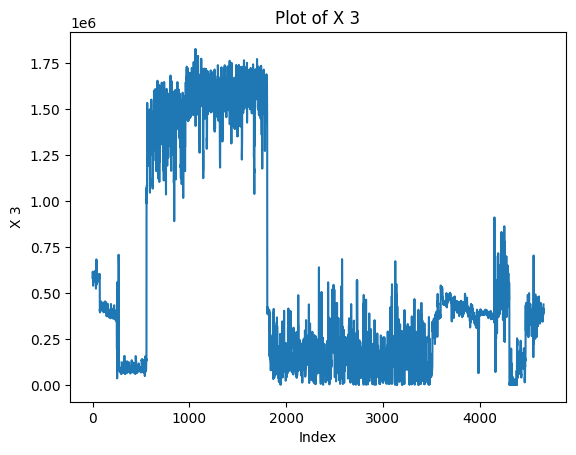

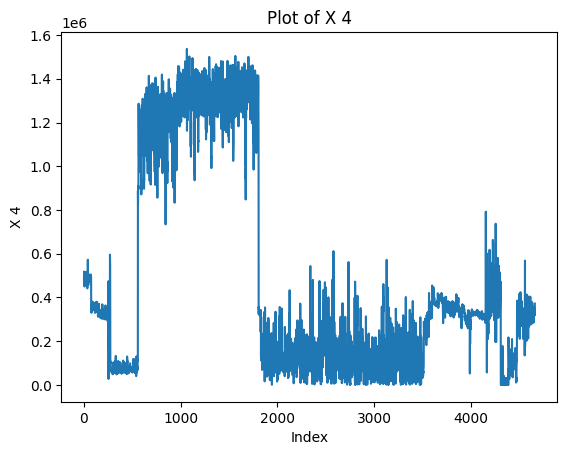

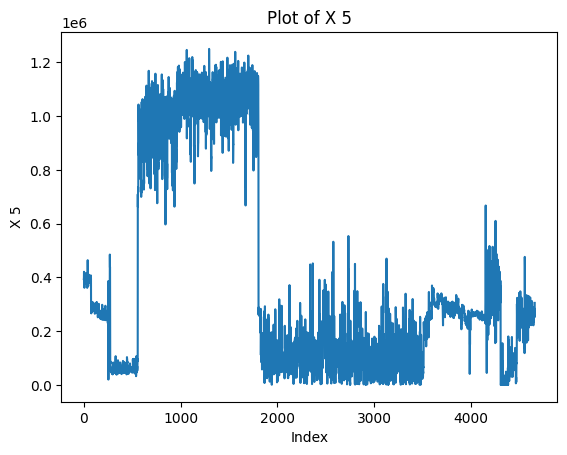

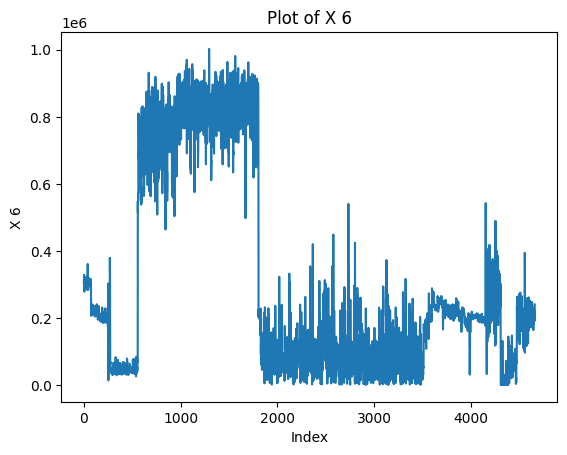

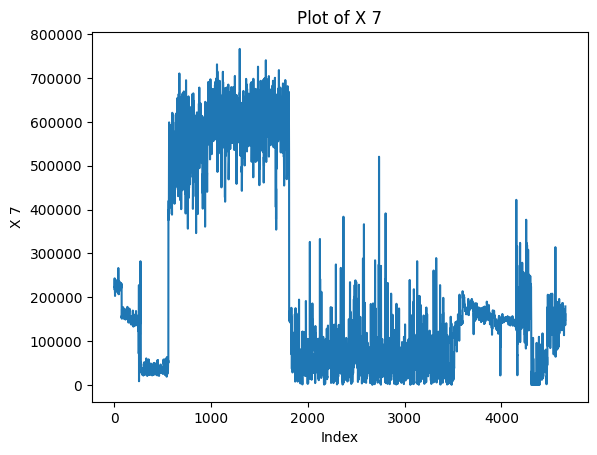

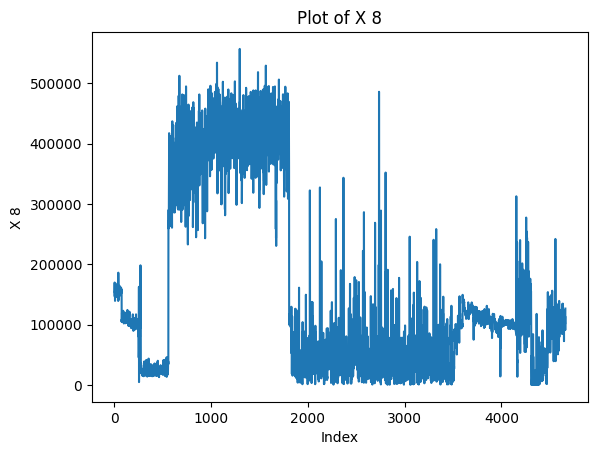

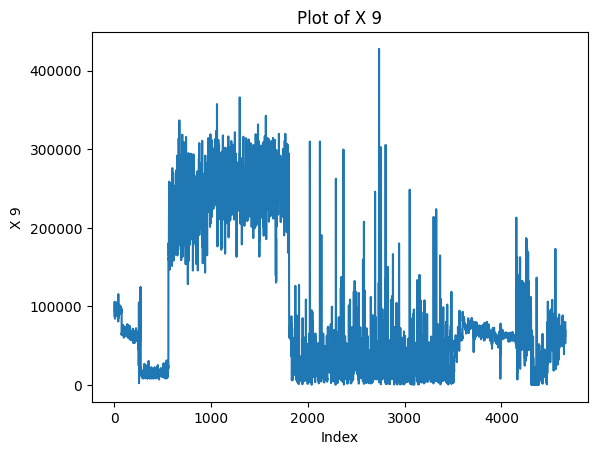

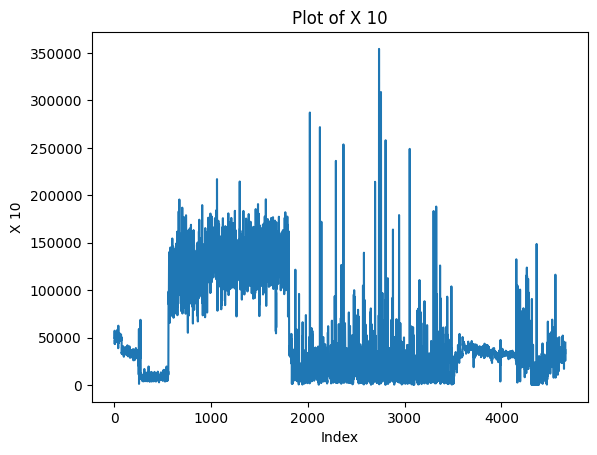

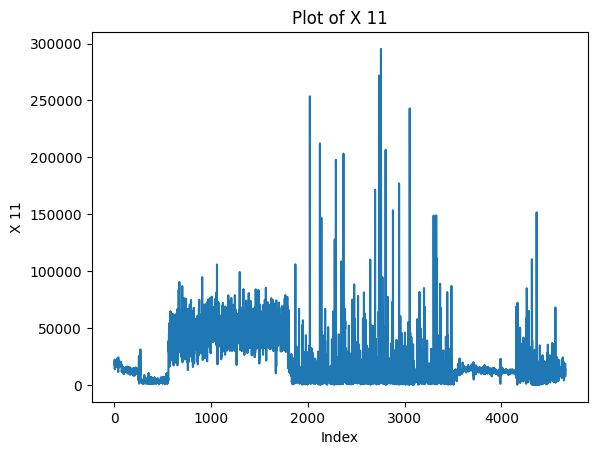

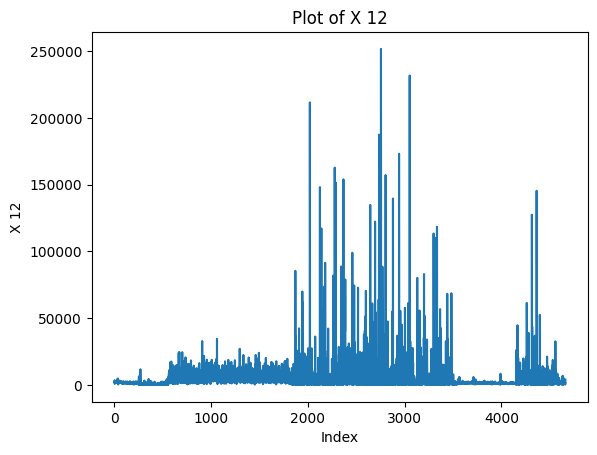

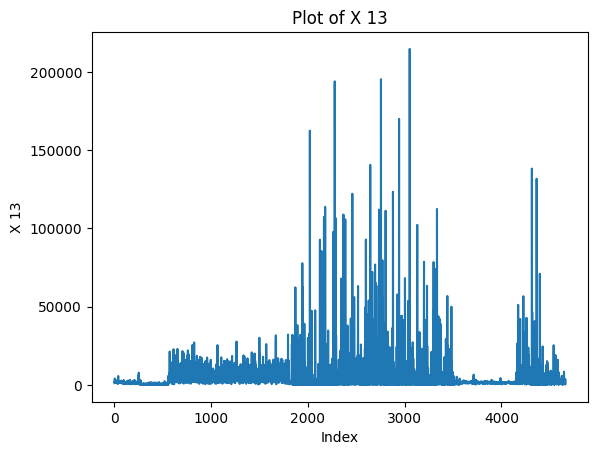

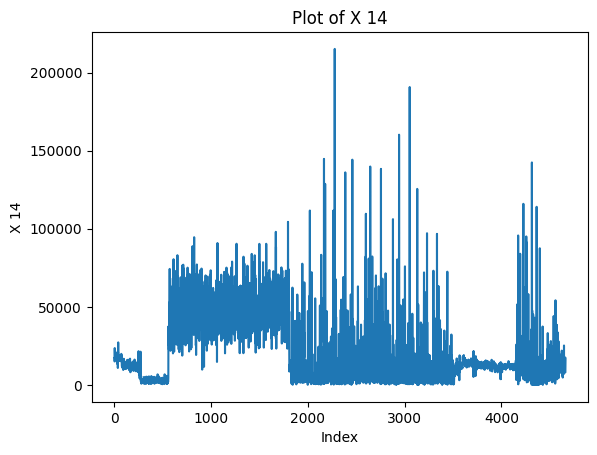

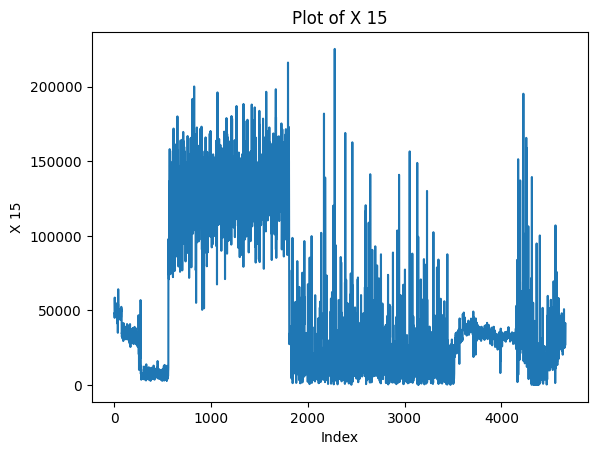

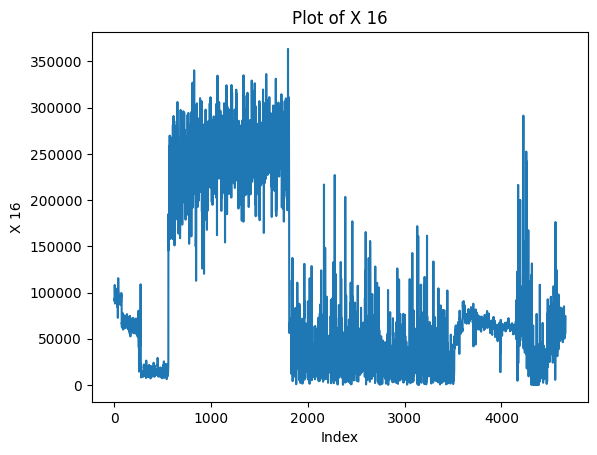

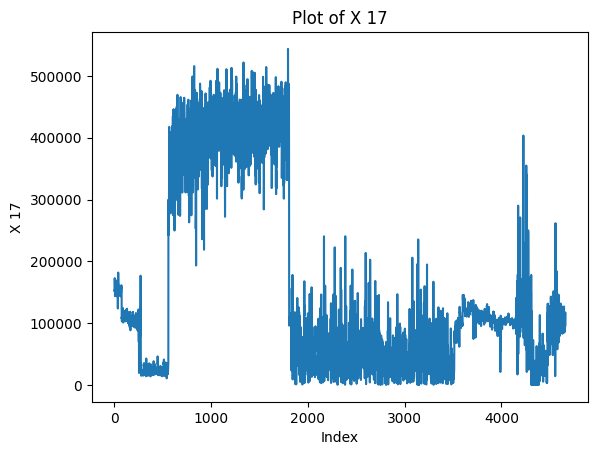

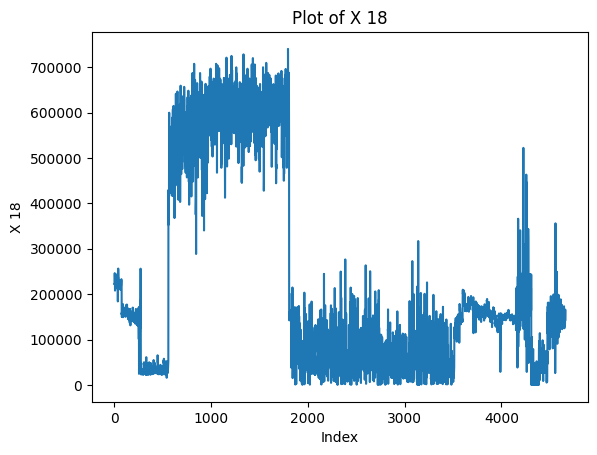

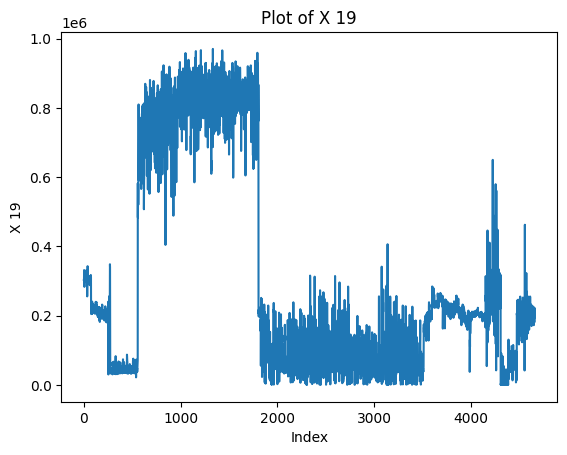

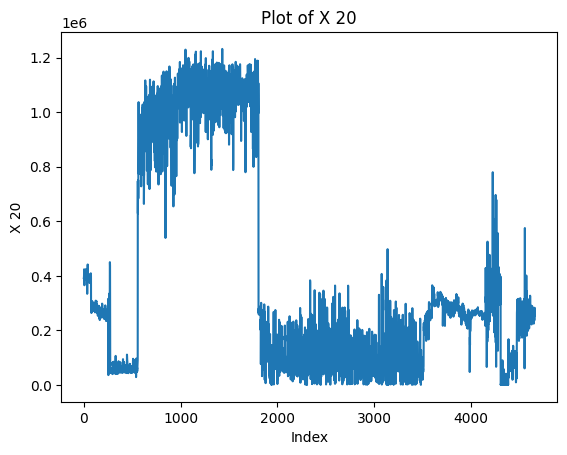

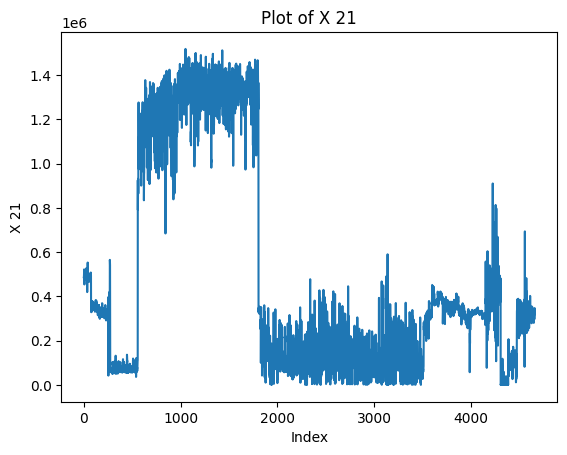

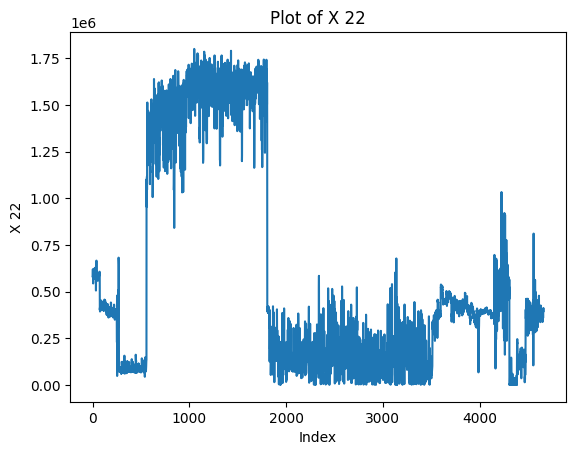

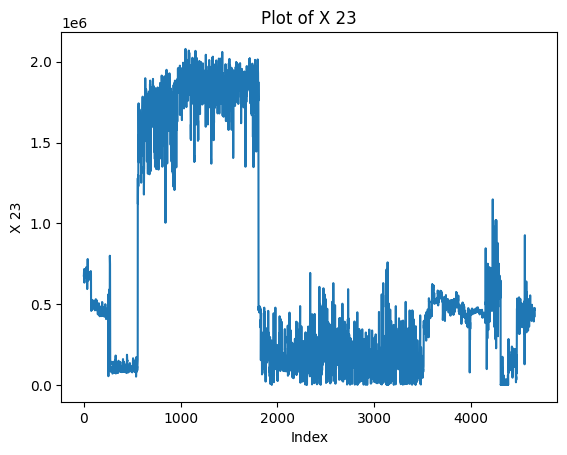

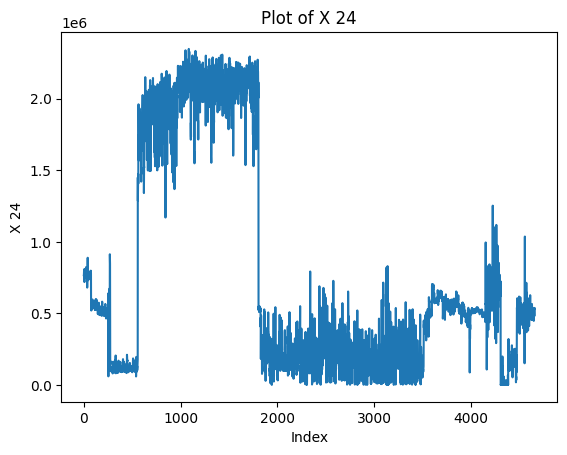

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

for column in X.columns:
    sns.lineplot(data=X[column])
    plt.xlabel('Index')
    plt.ylabel(f'X {column}')
    plt.title(f'Plot of X {column}')
    plt.show()
